# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
N = 100
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((100,), (100, 3))

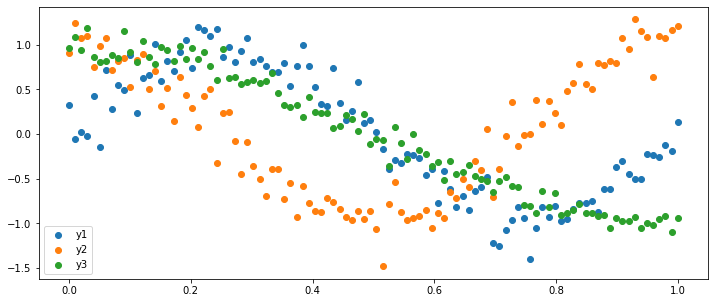

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((100,), (100, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((100, 1), (300, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((100, 1), (3, 1), (100, 1))

In [9]:
Xnew = pm.math.cartesian(x, task_i) # For prediction
Xnew.shape

(300, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [10]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [11]:
coreg.full(task_i).eval()

array([[19.33453182, -9.86302327, -6.12714231],
       [-9.86302327, 34.13251544,  3.50010381],
       [-6.12714231,  3.50010381,  4.8962007 ]])

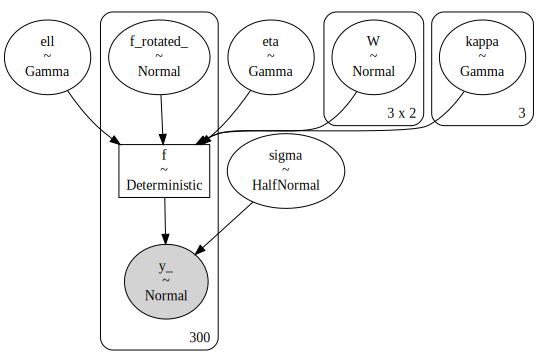

In [12]:
pm.model_to_graphviz(model)

In [13]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 627 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 31min 36s, sys: 49min 59s, total: 1h 21min 35s
Wall time: 10min 35s


#### Prediction

In [14]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 43.3 s, sys: 47.7 s, total: 1min 31s
Wall time: 13.6 s


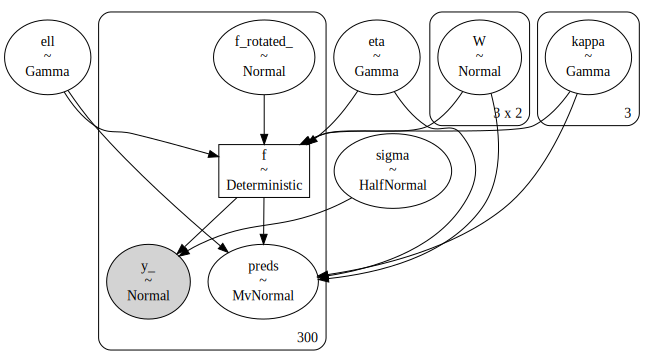

In [15]:
pm.model_to_graphviz(model)

In [16]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 300)

#### Plot the first GP

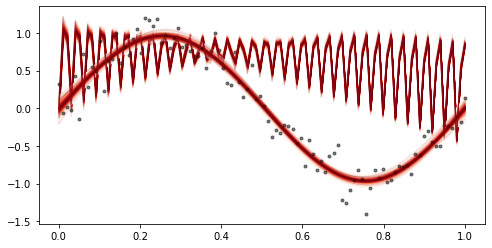

In [17]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], x)
plt.show()

#### Plot the second GP

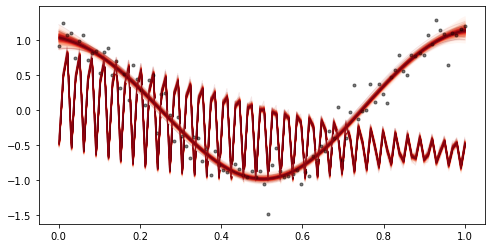

In [18]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, N:2*N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], x)
plt.show()

### Option 2.1: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [19]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((100, 1), (3, 1), (300, 2))

In [20]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [21]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((100, 100), (3, 3), (300, 300))

In [22]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 353 seconds.


CPU times: user 17min 51s, sys: 28min 57s, total: 46min 48s
Wall time: 5min 59s


#### Prediction

In [23]:
xnew = np.linspace(-0.5, 1.5, 500)
Xnew = pm.math.cartesian(xnew, task_i)

In [24]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 38min 25s, sys: 15min 35s, total: 54min
Wall time: 6min 56s


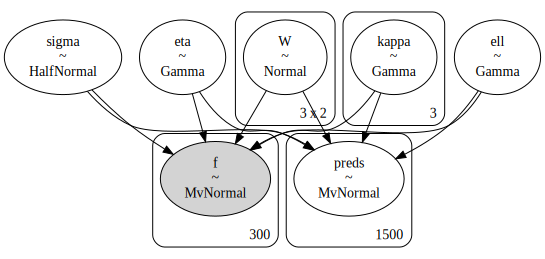

In [25]:
pm.model_to_graphviz(model)

In [26]:
Xnew.shape

(1500, 2)

In [27]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 1500)

#### Plot the GP prediction

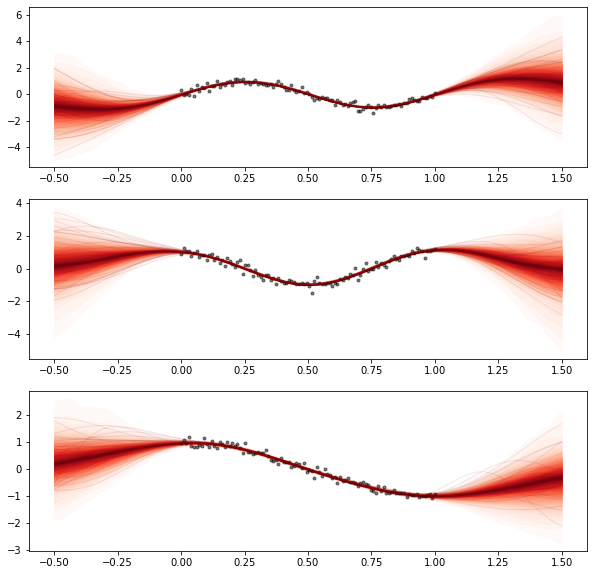

In [28]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [29]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.024,2.181,-4.384,3.703,0.125,0.088,304.0,300.0,NaN
"W[0, 1]",0.128,2.290,-4.063,4.200,0.128,0.090,336.0,342.0,NaN
"W[1, 0]",-0.019,2.110,-3.989,3.647,0.123,0.094,304.0,284.0,NaN
"W[1, 1]",0.117,2.034,-3.429,3.698,0.109,0.083,349.0,294.0,NaN
"W[2, 0]",0.004,0.968,-1.754,2.111,0.044,0.055,517.0,275.0,NaN
"W[2, 1]",-0.061,0.988,-1.873,1.851,0.053,0.054,383.0,233.0,NaN
ell,0.369,0.051,0.276,0.454,0.003,0.002,338.0,240.0,NaN
eta,0.747,0.289,0.305,1.260,0.016,0.012,338.0,352.0,NaN
kappa[0],1.855,1.463,0.008,4.459,0.061,0.044,367.0,127.0,NaN
kappa[1],1.909,1.367,0.043,4.229,0.061,0.044,435.0,295.0,NaN


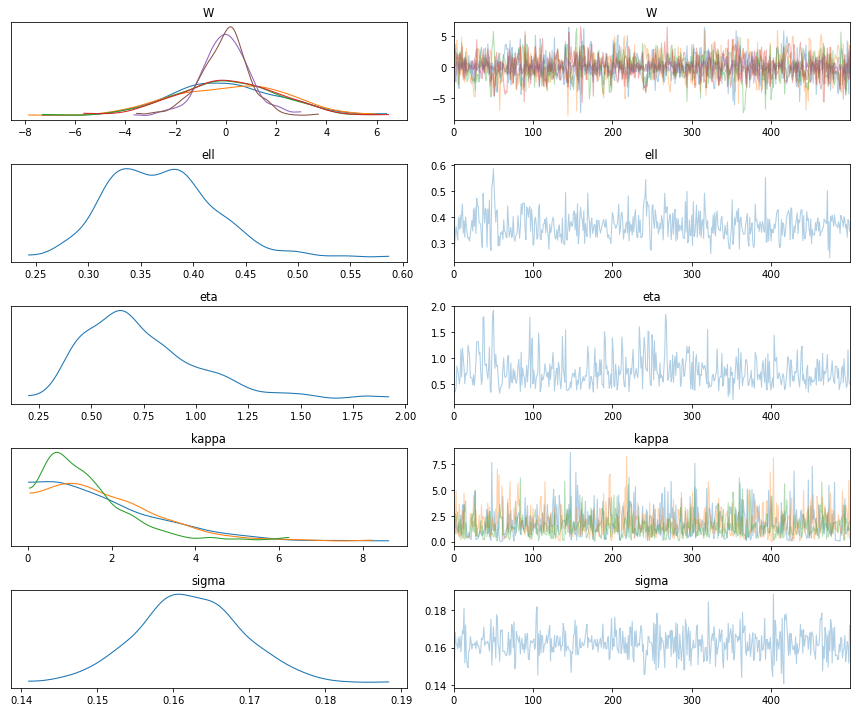

In [30]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Option 2.2: Implement LCM by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) \otimes K_2(o, o')
$$

In [31]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((100, 1), (3, 1), (300, 2))

In [32]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=3, beta=1)
    cov2 = eta2**2 * pm.gp.cov.Matern32(1, ls=ell2)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov+cov2, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [33]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((100, 100), (3, 3), (300, 300))

In [34]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 478 seconds.


CPU times: user 23min 49s, sys: 39min 17s, total: 1h 3min 6s
Wall time: 8min 5s


#### Prediction

In [35]:
xnew = np.linspace(-0.5, 1.5, 500)
Xnew = pm.math.cartesian(xnew, task_i)

In [36]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 40min 30s, sys: 20min 57s, total: 1h 1min 27s
Wall time: 7min 55s


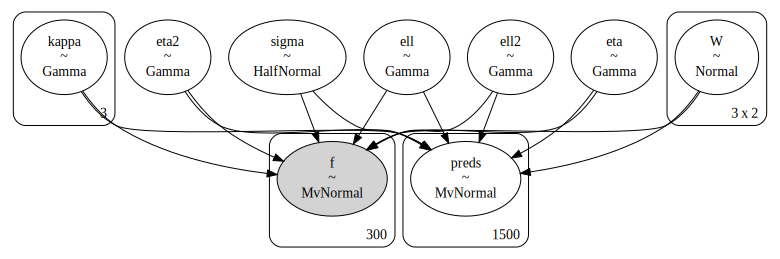

In [37]:
pm.model_to_graphviz(model)

In [38]:
Xnew.shape

(1500, 2)

In [39]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 1500)

#### Plot the GP prediction

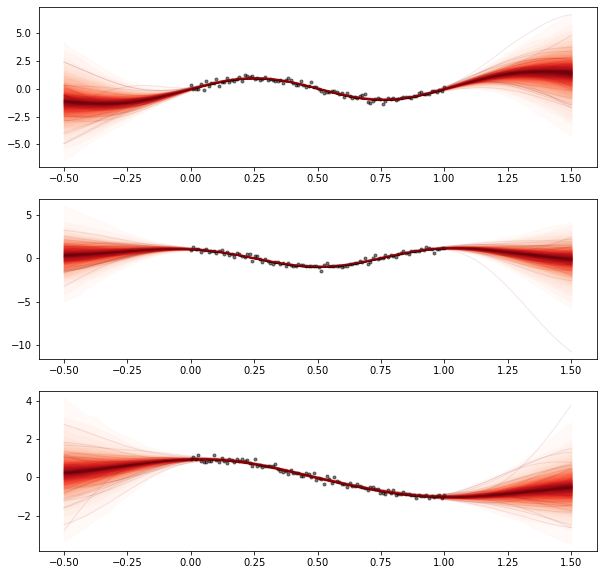

In [40]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [41]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.331,1.939,-4.091,3.088,0.113,0.080,295.0,399.0,NaN
"W[0, 1]",0.106,1.919,-2.839,4.309,0.091,0.093,443.0,301.0,NaN
"W[1, 0]",0.008,1.799,-3.065,3.833,0.084,0.084,466.0,311.0,NaN
"W[1, 1]",-0.091,1.867,-3.941,3.384,0.115,0.081,267.0,382.0,NaN
"W[2, 0]",-0.000,0.946,-1.974,1.586,0.050,0.047,431.0,232.0,NaN
"W[2, 1]",-0.048,0.947,-2.079,1.564,0.053,0.048,345.0,238.0,NaN
ell,0.390,0.054,0.286,0.488,0.003,0.002,424.0,359.0,NaN
eta,1.047,0.508,0.364,2.106,0.034,0.025,257.0,314.0,NaN
ell2,5.182,2.821,0.757,10.319,0.105,0.077,605.0,278.0,NaN
eta2,0.929,0.646,0.075,2.144,0.030,0.024,494.0,309.0,NaN


In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 06 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

arviz     : 0.12.1
matplotlib: 3.5.2
pymc      : 4.1.5
numpy     : 1.22.4

Watermark: 2.3.0

